In [1]:
%cd '/scratch/sk7898/l3embedding/classifier/sonyc_ust'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import random
import csv
import json
import glob
import pandas as pd
import numpy as np
import resampy
import tensorflow as tf
import soundfile as sf
import librosa
import keras
from keras.models import load_model
from metrics import parse_coarse_prediction, micro_averaged_auprc, macro_averaged_auprc, evaluate_df
from classify import load_embeddings, predict_mil, construct_mlp_mil
# New modules: oyaml and pandas
import oyaml as yaml

/scratch/sk7898/l3embedding/classifier/sonyc_ust


Using TensorFlow backend.


In [ ]:
def write_to_output(y_pred, output_path, test_file_list, annotation_data, taxonomy):
    
    coarse_fine_labels = [["{}-{}_{}".format(coarse_id, fine_id, fine_label)
                           for fine_id, fine_label in fine_dict.items()]
                          for coarse_id, fine_dict in taxonomy['fine'].items()]
        
    full_fine_target_labels = [fine_label for fine_list in coarse_fine_labels
                               for fine_label in fine_list]
        
    coarse_target_labels = ["_".join([str(k), v])
                            for k, v in taxonomy['coarse'].items()]
    
    annotation = annotation_data.sort_values('audio_filename')[['split', 'sensor_id', 'audio_filename']].drop_duplicates()
    annotation = annotation[annotation['audio_filename'].isin(test_file_list)]
    split_list = annotation['split'].tolist()
    sensor_list = annotation['sensor_id'].tolist()
    
    with open(output_path, 'w') as f:
        csvwriter = csv.writer(f)

        # Write fields
        fields = ["split", "sensor_id", "audio_filename"] + full_fine_target_labels + coarse_target_labels
        csvwriter.writerow(fields)

        # Write results for each file to CSV
        for split, sid, filename, y in zip(split_list, sensor_list, test_file_list, y_pred):
            row = [split, sid, filename]

            # Add placeholder values for fine level
            row += [0.0 for _ in range(len(full_fine_target_labels))]
            # Add coarse level labels
            row += list(y)

            csvwriter.writerow(row)

In [ ]:
def filter_ground_truth_split(ann_df, aggregate=True, valid_sensor_ids=None, split_path=None, split=None):
    
    if split and not valid_sensor_ids:
        #gt_df = ann_df[(ann_df["annotator_id"] > 0) & (ann_df['split'] == split)]
        gt_df = ann_df[(ann_df["annotator_id"] == 0) & (ann_df['split'] == split)]
    elif split and valid_sensor_ids:
        gt_df = ann_df[(ann_df["annotator_id"] == 0) & (ann_df['split'] == split) & (ann_df['sensor_id'].isin(valid_sensor_ids))]
    else:
        gt_df = ann_df[ann_df["annotator_id"] == 0]
    
    if aggregate:
        gt_df = gt_df.groupby("audio_filename", group_keys=False).max()
    
    gt_df.reset_index(inplace=True)
    if 'index' in gt_df.keys():
        gt_df = gt_df.drop(columns=['index'])
    return gt_df

In [ ]:
def parse_ground_truth(annotation_path, yaml_path, valid_sensor_ids=None, split_path=None, split=None):

    # Create dictionary to parse tags
    with open(yaml_path, 'r') as stream:
        yaml_dict = yaml.load(stream, Loader=yaml.Loader)

    # Load CSV file into a Pandas DataFrame.
    ann_df = pd.read_csv(annotation_path)
    gt_df = filter_ground_truth_split(ann_df,
                                      valid_sensor_ids=valid_sensor_ids,
                                      split_path=split_path,
                                      split=split)

    # Rename coarse columns.
    coarse_dict = yaml_dict["coarse"]
    coarse_renaming = {
        "_".join([str(c), coarse_dict[c], "presence"]): str(c)
        for c in coarse_dict}
    gt_df = gt_df.rename(columns=coarse_renaming)

    # Collect tag names as strings and map them to mixed (coarse-fine) ID pairs.
    # The "mixed key" is a hyphenation of the coarse ID and fine ID.
    fine_dict = {}
    for coarse_id in yaml_dict["fine"]:
        for fine_id in yaml_dict["fine"][coarse_id]:
            mixed_key = "-".join([str(coarse_id), str(fine_id)])
            fine_dict[mixed_key] = yaml_dict["fine"][coarse_id][fine_id]

    # Rename fine columns.
    fine_renaming = {"_".join([k, fine_dict[k], "presence"]): k
        for k in fine_dict}
    gt_df = gt_df.rename(columns=fine_renaming)

    # Loop over coarse tags.
    n_samples = len(gt_df)
    coarse_dict = yaml_dict["coarse"]
    for coarse_id in yaml_dict["coarse"]:
        # Construct incomplete fine tag by appending -X to the coarse tag.
        incomplete_tag = str(coarse_id) + "-X"

        # If the incomplete tag is not in the prediction, append a column of zeros.
        # This is the case e.g. for coarse ID 7 ("dogs") which has a single
        # fine-level tag ("7-1_dog-barking-whining") and thus no incomplete
        # tag 7-X.
        if incomplete_tag not in gt_df.columns:
            gt_df[incomplete_tag] = np.zeros((n_samples,)).astype('int')

    gt_df = gt_df.sort_values('audio_filename')

    gt_df.reset_index(inplace=True)
    if 'index' in gt_df.keys():
        gt_df = gt_df.drop(columns=['index'])

    # Return output in DataFrame format.
    return gt_df

In [ ]:
def evaluate(prediction_path, annotation_path, yaml_path, mode, 
             valid_sensor_ids=None,
             split_path=None, 
             per_sensor=False, 
             split=None):

    with open(yaml_path, 'r') as stream:
        yaml_dict = yaml.load(stream, Loader=yaml.Loader)

    # Parse ground truth.
    gt_df = parse_ground_truth(annotation_path, yaml_path,
                               valid_sensor_ids=valid_sensor_ids,
                               split_path=split_path,
                               split=split)

    # Parse predictions.
    if mode == "fine":
        pred_df = parse_fine_prediction(prediction_path, yaml_path)
    elif mode == "coarse":
        pred_df = parse_coarse_prediction(prediction_path, yaml_path)
    
    flist = [value for value in gt_df['audio_filename'].unique().tolist() 
             if value in pred_df['audio_filename'].unique().tolist()] 
    pred_df = pred_df[pred_df['audio_filename'].isin(flist)]
    gt_df = gt_df[gt_df['audio_filename'].isin(flist)]

    if per_sensor:
        return evaluate_sensor_df(gt_df, pred_df, mode, yaml_dict, split=split)
    else:
        return evaluate_df(gt_df, pred_df, mode, yaml_dict)

In [ ]:
def evaluate_sensor_df(gt_df, pred_df, mode, yaml_dict, split=None):
    
    dicts = {}
    split = split if split else 'validate'
    sids = pred_df[pred_df['split'] == split]['sensor_id'].unique().tolist()
        
    for sid in sids:
        gt = gt_df[(gt_df['split'] == split) & (gt_df['sensor_id'] == sid)]
        pred = pred_df[(pred_df['split'] == split) & (pred_df['sensor_id'] == sid)]
        gt = gt.drop(columns=['split', 'sensor_id'])
        pred = pred.drop(columns=['split', 'sensor_id'])
        dicts[sid] = evaluate_df(gt, pred, mode, yaml_dict)
    return dicts

In [ ]:
emb_dir = '/scratch/dr2915/embeddings/features/sonyc_ust/l3/melSpec_20200304183233_48000_256_242_2048'
annotation_path = '/beegfs/dr2915/sonyc_ust/data/annotations.csv'
taxonomy_path = '/beegfs/dr2915/sonyc_ust/data/dcase-ust-taxonomy.yaml'
cls_path = '/scratch/dr2915/embeddings/classifier/sonyc_ust/mil/melSpec_20200304183233_48000_256_242_2048/0_0/results'
output_path = os.path.join(cls_path, 'output_1.csv')
annotation_data = pd.read_csv(annotation_path).sort_values('audio_filename')

with open(taxonomy_path, 'r') as f:
    taxonomy = yaml.load(f, Loader=yaml.Loader)

annotation_data = pd.read_csv(annotation_path).sort_values('audio_filename')
with open(taxonomy_path, 'r') as f:
    taxonomy = yaml.load(f, Loader=yaml.Loader)

# annotation_subset = annotation_data[(annotation_data['split'] == split) & 
#                                     (annotation_data.sort_values('sensor_id')['sensor_id'] == s_id)
#                                    ]
file_list = annotation_data.sort_values('audio_filename')['audio_filename'].unique().tolist()

In [ ]:
embeddings = load_embeddings(file_list, emb_dir)
X = np.array(embeddings)
_, num_frames, emb_size = X.shape

num_classes = 8
model_weight_file = os.path.join(cls_path, 'model_best.h5')
model = construct_mlp_mil(num_frames,
                          emb_size,
                          num_classes,
                          num_hidden_layers=0,
                          hidden_layer_size=0)

model.load_weights(model_weight_file)

pred = model.predict(X)
print(pred.shape)

# Discard auxilliary predictions
if type(pred) == list:
    pred = pred[0]

pred.tolist()
write_to_output(pred, output_path, file_list, annotation_data, taxonomy)

In [ ]:
common = True
split = 'test'

out = pd.read_csv(output_path)
l1 = out[out['split'] == 'test']['sensor_id'].unique().tolist()
l2 = out[out['split'] == 'train']['sensor_id'].unique().tolist()

if common:
    test_sids = out[(out['sensor_id'].isin(l1)) & (out['sensor_id'].isin(l2))]['sensor_id'].unique().tolist()
else:
    test_sids = out[(out['sensor_id'].isin(l1)) & (~out['sensor_id'].isin(l2))]['sensor_id'].unique().tolist()

df_dicts = evaluate(
                    output_path,
                    annotation_path,
                    taxonomy_path, 
                    mode='coarse',
                    valid_sensor_ids=None,
                    per_sensor=True,
                    split=split
            )

In [ ]:
metrics = {}
sensor_df = pd.read_csv('/scratch/sk7898/l3embedding/notebooks/data/sensor_split_ids.csv')

for sensor, df_dict in df_dicts.items():
    metrics[sensor] = {}
    micro_auprc, eval_df = micro_averaged_auprc(df_dict, return_df=True)
    macro_auprc, class_auprc = macro_averaged_auprc(df_dict, return_classwise=True)

    # Get index of first threshold that is at least 0.5
    thresh_0pt5_idx = (eval_df['threshold'] >= 0.5).to_numpy().nonzero()[0][0]

    metrics[sensor]["sensor_name"] = sensor_df[sensor_df['sensor_id'] == sensor]['sensor_name'].tolist()[0]
    metrics[sensor]["micro_auprc"] = micro_auprc
    metrics[sensor]["micro_f1"] = eval_df["F"][thresh_0pt5_idx]
    metrics[sensor]["macro_auprc"] = macro_auprc

#     print(" **** sensor_id: {}".format(sensor))
#     print("{} level evaluation:".format(mode.capitalize()))
#     print("======================")
#     print(" * Micro AUPRC:           {}".format(metrics[sensor]["micro_auprc"]))
#     print(" * Micro F1-score (@0.5): {}".format(metrics[sensor]["micro_f1"]))
#     print(" * Macro AUPRC:           {}".format(metrics[sensor]["macro_auprc"]))
    
#     print(" * Coarse Tag AUPRC:")
#     metrics[sensor]["class_auprc"] = {}
#     for coarse_id, auprc in class_auprc.items():
#         coarse_name = taxonomy['coarse'][int(coarse_id)]
#         metrics[sensor]["class_auprc"][coarse_name] = auprc
#         print("      - {}: {}".format(coarse_name, auprc))

In [ ]:
result = pd.DataFrame.from_dict(metrics, orient='index')
result

In [ ]:
result.to_csv('/scratch/sk7898/l3embedding/notebooks/data/per_sensor_{}.csv'.format(split))

In [12]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

test1 = pd.read_csv('/scratch/sk7898/l3embedding/notebooks/data/per_sensor_test.csv')
val1 = pd.read_csv('/scratch/sk7898/l3embedding/notebooks/data/per_sensor_validate.csv')

In [3]:
val = val1[~val1['sensor_id'].isin([0, 2])]
test = test1[~test1['sensor_id'].isin([0, 2])]
# v_a = val[~val['sensor_id'].isin([0, 2])]['micro_auprc'].mean()
# v_f = val[~val['sensor_id'].isin([0, 2])]['micro_f1'].mean()
# t_a = test[~test['sensor_id'].isin([0, 2])]['micro_auprc'].mean()
# t_f = test[~test['sensor_id'].isin([0, 2])]['micro_f1'].mean()

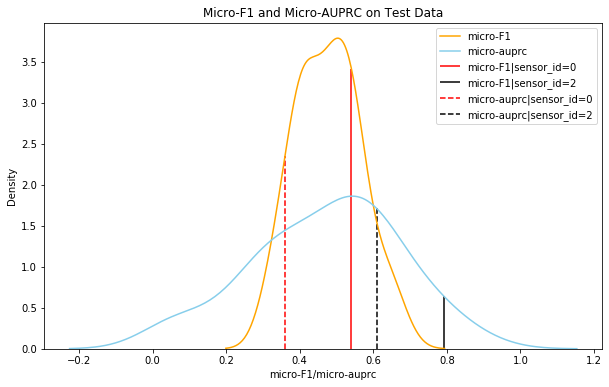

In [33]:
s0_1 = test1[test1['sensor_id'] == 0]["micro_f1"][0]
s2_1 = test1[test1['sensor_id'] == 2]["micro_f1"][2]
s0_2 = test1[test1['sensor_id'] == 0]["micro_auprc"][0]
s2_2 = test1[test1['sensor_id'] == 2]["micro_auprc"][2]

fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(test["micro_f1"], color='orange', label='micro-F1', ax=ax)
xf, yf = ax.lines[0].get_data()
y0_1 = np.interp(s0_1, xf, yf)
y2_1 = np.interp(s2_1, xf, yf)

sns.kdeplot(test["micro_auprc"], color='skyblue', label='micro-auprc', ax=ax)
xa, ya = ax.lines[1].get_data()
y0_2 = np.interp(s0_2, xa, ya)
y2_2 = np.interp(s2_2, xa, ya)

plt.vlines(s0_1, ymin=0, ymax=y0_1, color='red', label='micro-F1|sensor_id=0')
plt.vlines(s2_1, ymin=0, ymax=y2_1, color='black', label='micro-F1|sensor_id=2')
plt.vlines(s0_2, ymin=0, ymax=y0_2, color='red', ls='--', label='micro-auprc|sensor_id=0')
plt.vlines(s2_2, ymin=0, ymax=y2_2, color='black', ls='--', label='micro-auprc|sensor_id=2')
plt.legend()
plt.title('Micro-F1 and Micro-AUPRC on Test Data')
plt.xlabel('micro-F1/micro-auprc')
plt.show()

In [5]:
p = '/scratch/work/sonyc/'
for f in os.listdir(p):
    print(f)

PermissionError: [Errno 13] Permission denied: '/scratch/work/sonyc/'